In [5]:
# installing langchain, evaluation framework, openai, headless vector database
!pip install langchain arize-phoenix transformers openai langchain_openai chromadb pypdf pdf2image unstructured pdfminer.six

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 143.4 kB/s eta 0:00:00 kB/s eta 0:00:01
  Using cached openai-1.9.0-py3-none-any.whl.metadata (18 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 492.2 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 402.1 kB/s eta 0:00:00m eta 0:00:010:00:01
  Preparing metadata (setup.py) ... done
  Using cached backoff-2.2.1-py3-none-any.whl (15 kB)
  Using cached huggingface_hub-0.20.3-py3-none-any.whl.metadata (12 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 499.0 kB/s eta 0:00:00 kB/s eta 0:00:01
  Using cached fsspec-2023.12.2-py3-none-any.whl.metadata (6.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 709.2 kB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 1.0 MB/s eta 0:00:00m eta 0:00:010:00:01
Using cached openai-1.9.0-py3-none-any.whl (223 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 1.4 

In [3]:
import os

from langchain.chains import LLMChain, RetrievalQA
from langchain.chains.conversational_retrieval.prompts import QA_PROMPT
from langchain_community.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [4]:
from langchain_openai import ChatOpenAI

In [5]:
# loading dataset
from langchain.document_loaders import TextLoader
from langchain_community.document_loaders import PyPDFLoader

## Simple RAG framework

In [6]:
from langchain.document_loaders import WebBaseLoader
loader = WebBaseLoader('https://en.wikipedia.org/wiki/NASA')
data = loader.load()

In [7]:
# chunk the text to embed
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size= 600, chunk_overlap=10)
all_splits = text_splitter.split_documents(data)

In [8]:
# store chunk of text
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=all_splits, embedding=OpenAIEmbeddings())

In [9]:
# through llm
from langchain_openai import ChatOpenAI
chat_llm = ChatOpenAI(model_name='gpt-3.5-turbo', temperature=0)

In [10]:
# initialize chain
from langchain.chains import RetrievalQA
chain = RetrievalQA.from_chain_type(
    llm = chat_llm,
    chain_type = 'stuff',
    retriever = vectorstore.as_retriever(search_kwargs={'k': 4})
)

In [11]:
# query the chain for retrieval
query = 'role of NASA'
response = chain.invoke(query)
response

{'query': 'role of NASA',
 'result': "The role of NASA is to conduct scientific research and exploration in the field of space. NASA's main objectives include expanding human knowledge through new scientific discoveries, extending human presence to the Moon and Mars for sustainable long-term exploration, catalyzing economic growth and driving innovation to address national challenges, and enhancing capabilities and operations for mission success. NASA collaborates with other space agencies, such as the European Space Agency, to support joint missions and share resources and expertise."}

## RAG Evaluations

In [12]:
# for running evaluations in async 

import nest_asyncio
nest_asyncio.apply()

In [13]:
import phoenix as px
from phoenix.experimental.evals import (
    HALLUCINATION_PROMPT_RAILS_MAP,
    HALLUCINATION_PROMPT_TEMPLATE,
    OpenAIModel,
    llm_classify,
)

session = px.launch_app()

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [14]:
print(HALLUCINATION_PROMPT_TEMPLATE)


In this task, you will be presented with a query, a reference text and an answer. The answer is
generated to the question based on the reference text. The answer may contain false information, you
must use the reference text to determine if the answer to the question contains false information,
if the answer is a hallucination of facts. Your objective is to determine whether the reference text
contains factual information and is not a hallucination. A 'hallucination' in this context refers to
an answer that is not based on the reference text or assumes information that is not available in
the reference text. Your response should be a single word: either "factual" or "hallucinated", and
it should not include any other text or characters. "hallucinated" indicates that the answer
provides factually inaccurate information to the query based on the reference text. "factual"
indicates that the answer to the question is correct relative to the reference text, and does not
contain made up inf

In [15]:
from phoenix.trace.langchain import OpenInferenceTracer, LangChainInstrumentor

In [16]:
tracer = OpenInferenceTracer()
LangChainInstrumentor(tracer).instrument()

### Include RAG flow after attaching the tracer to session

In [17]:

from langchain.document_loaders import WebBaseLoader
loader = WebBaseLoader('https://en.wikipedia.org/wiki/NASA')
data = loader.load()

# chunk the text to embed
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size= 600, chunk_overlap=10)
all_splits = text_splitter.split_documents(data)

# store chunk of text
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=all_splits, embedding=OpenAIEmbeddings())

# through llm
from langchain_openai import ChatOpenAI
chat_model = ChatOpenAI(model_name='gpt-3.5-turbo', temperature=0)

# initialize chain
from langchain.chains import RetrievalQA
chain = RetrievalQA.from_chain_type(
    llm = chat_model,
    chain_type = 'stuff',
    retriever = vectorstore.as_retriever(search_kwargs={'k': 4})
)

# query the chain for retrieval
query = 'role of NASA'
response = chain.invoke(query)
response



{'query': 'role of NASA',
 'result': 'The role of NASA is to conduct research and exploration in the fields of space and aeronautics. Its main objectives include expanding human knowledge through scientific discoveries, extending human presence to the Moon and Mars, catalyzing economic growth and innovation, and enhancing capabilities and operations for mission success. NASA is responsible for leading American space exploration efforts and has been involved in various missions, including the Apollo Moon landing missions and the operation of the International Space Station.'}

### Invoking query to RAG  - check traces being streamed to phoenix dashboard @ http://localhost:6006/

In [18]:
# query the chain for retrieval
query = 'where is NASAs headquarter?'
response = chain.invoke(query)
response

{'query': 'where is NASAs headquarter?',
 'result': 'NASA\'s headquarters is located in Washington, D.C. at the following coordinates: 38°52\'59"N 77°0\'59"W.'}

In [83]:
# query the chain for retrieval
query = 'what is the first moon landing? '
response = chain.invoke(query)
response

{'query': 'what is the first moon landing? ',
 'result': 'The first moon landing refers to the historic event when the Apollo 11 mission successfully landed astronauts Neil Armstrong and Buzz Aldrin on the surface of the Moon on July 20, 1969. It was a significant achievement in human space exploration and marked the first time that humans set foot on another celestial body.'}

### Phoenix evaluations - fetching traces from phoenix session

In [19]:
from phoenix.session.evaluation import get_qa_with_reference, get_retrieved_documents
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

In [20]:
queries_df = get_qa_with_reference(session)
queries_df

,input,output,reference
context.span_id,,,
fe8d53af-bc58-42f6-bf8b-660da9b3fa8e,where is NASAs headquarter?,"NASA's headquarters is located in Washington, ...",National Aeronautics and Space AdministrationN...
83160d6b-8084-455e-a536-c1b6c89bd611,role of NASA,The role of NASA is to conduct research and ex...,The National Aeronautics and Space Administrat...


In [21]:
retrieved_docs_df = get_retrieved_documents(session)
retrieved_docs_df

context.trace_id  \
context.span_id                      document_position                                         
c3e16e16-841c-490c-8957-973037d2630e 0                  0fc597cf-78c3-4078-84e2-007d3981b246   
                                     1                  0fc597cf-78c3-4078-84e2-007d3981b246   
                                     2                  0fc597cf-78c3-4078-84e2-007d3981b246   
                                     3                  0fc597cf-78c3-4078-84e2-007d3981b246   
f510bbda-f4bd-4304-84ae-1422af57883c 0                  38e41d4c-5eff-417c-a247-fee6bfb959a2   
                                     1                  38e41d4c-5eff-417c-a247-fee6bfb959a2   
                                     2                  38e41d4c-5eff-417c-a247-fee6bfb959a2   
                                     3                  38e41d4c-5eff-417c-a247-fee6bfb959a2   

                                                                              input  \
context.span_id                      document_position                                
c3e16e16-841c-490c-8957-973037d2630e 0                  where is NASAs headquarter?   
                                     1                  where is NASAs headquarter?   
                                     2                  where is NASAs headquarter?   
                                     3                  where is NASAs headquarter?   
f510bbda-f4bd-4304-84ae-1422af57883c 0                                 role of NASA   
                                     1                                 role of NASA   
                                     2                                 role of NASA   
                                     3                                 role of NASA   

                                                                                                reference  \
context.span_id                      document_position                                                      
c3e16e16-841c-490c-8957-973037d2630e 0                  National Aeronautics and Space AdministrationN...   
                                     1                  National Aeronautics and Space AdministrationN...   
                                     2                  The Explorer program office is based at NASA G...   
                                     3                  The Explorer program office is based at NASA G...   
f510bbda-f4bd-4304-84ae-1422af57883c 0                  The National Aeronautics and Space Administrat...   
                                     1                  The National Aeronautics and Space Administrat...   
                                     2                  Expand human knowledge through new scientific ...   
                                     3                  Expand human knowledge through new scientific ...   

                                                       document_score  
context.span_id                      document_position                 
c3e16e16-841c-490c-8957-973037d2630e 0                           None  
                                     1                           None  
                                     2                           None  
                                     3                           None  
f510bbda-f4bd-4304-84ae-1422af57883c 0                           None  
                                     1                           None  
                                     2                           None  
                                     3                           None

### Setting model to use evaluations on

In [22]:
eval_model = OpenAIModel(
    model_name="gpt-4-1106-preview",
)

### Evaluations Method 1

In [33]:
rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
hallucination_classifications = llm_classify(
    dataframe=queries_df, template=HALLUCINATION_PROMPT_TEMPLATE, model=eval_model, rails=rails, concurrency=20
)["label"].tolist()
hallucination_classifications

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

['factual']

              precision    recall  f1-score   support

hallucinated       0.00      0.00      0.00         0
     factual       1.00      1.00      1.00         1

   micro avg       1.00      1.00      1.00         1
   macro avg       0.50      0.50      0.50         1
weighted avg       1.00      1.00      1.00         1



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

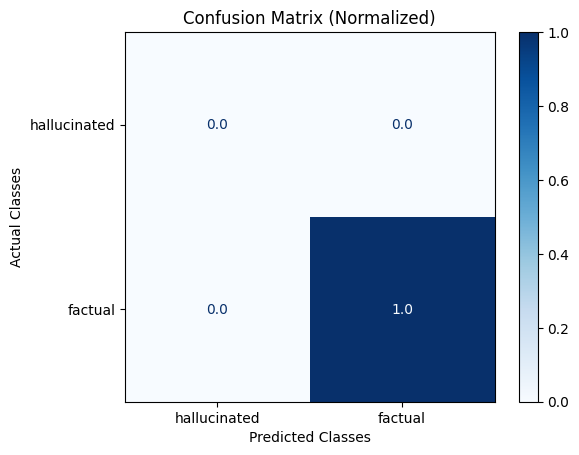

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pycm import ConfusionMatrix

import warnings
warnings.filterwarnings('ignore') 


true_labels = ['factual'] # , 'factual', 'factual'
print(classification_report(true_labels, hallucination_classifications, labels=rails))

confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=hallucination_classifications,
    classes=rails,
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

In [36]:
hallucination_classifications_df = llm_classify(
    dataframe=queries_df,
    template=HALLUCINATION_PROMPT_TEMPLATE,
    model=eval_model,
    rails=rails,
    provide_explanation=True,
    verbose=True,
    concurrency=20,
)

Using prompt:


In this task, you will be presented with a query, a reference text and an answer. The answer is
generated to the question based on the reference text. The answer may contain false information, you
must use the reference text to determine if the answer to the question contains false information,
if the answer is a hallucination of facts. Your objective is to determine whether the reference text
contains factual information and is not a hallucination. A 'hallucination' in this context refers to
an answer that is not based on the reference text or assumes information that is not available in
the reference text.

    [BEGIN DATA]
    ************
    [Query]: {input}
    ************
    [Reference text]: {reference}
    ************
    [Answer]: {output}
    ************
    [END DATA]

    Is the answer above factual or hallucinated based on the query and reference text?

Please read the query, reference text and answer carefully, then write out in a step by step manner


llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

- Snapped 'factual' to rail: factual


In [37]:
import pandas as pd
merged_df = pd.merge(
    queries_df, hallucination_classifications_df, left_index=True, right_index=True
)
merged_df

,input,output,reference,label,explanation
context.span_id,,,,,
e588bbc0-14ce-43dd-ae53-5b2d7eea694b,role of NASA,The role of NASA is to conduct research and ex...,The National Aeronautics and Space Administrat...,factual,The answer provided aligns with the informatio...


In [38]:
import numpy as np
y_true = true_labels
y_pred = merged_df["label"]

# y_pred
# Compute Per-Class Precision, Recall, F1 Score, Support
precision, recall, f1, support = precision_recall_fscore_support(true_labels, merged_df["label"])

In [39]:
precision, recall, f1, support 

(array([1.]), array([1.]), array([1.]), array([1]))

In [102]:
merged_df['reference'][0]

"The first lunar landing was conducted by Apollo\xa011. Commanded by Neil Armstrong with astronauts Buzz Aldrin and Michael Collins, Apollo\xa011 was one of the most significant missions in NASA's history, marking the end of the Space Race when the Soviet Union gave up its lunar ambitions. As the first human to step on the surface of the Moon, Neil Armstrong uttered the now famous words:\n\nThe first lunar landing was conducted by Apollo\xa011. Commanded by Neil Armstrong with astronauts Buzz Aldrin and Michael Collins, Apollo\xa011 was one of the most significant missions in NASA's history, marking the end of the Space Race when the Soviet Union gave up its lunar ambitions. As the first human to step on the surface of the Moon, Neil Armstrong uttered the now famous words:\n\nLaunch of Apollo 11\n\nLaunch of Apollo 11"

### Evaluations Method 2

In [23]:
from phoenix.experimental.evals import (
    HallucinationEvaluator,
    QAEvaluator,
    RelevanceEvaluator,
    run_evals,
)
from phoenix.trace import DocumentEvaluations, SpanEvaluations

#### Hallucination and QA correctness 

In [24]:
hallucination_evaluator = HallucinationEvaluator(eval_model)
qa_correctness_evaluator = QAEvaluator(eval_model)

hallucination_eval_df, qa_correctness_eval_df = run_evals(
    dataframe=queries_df,
    evaluators=[hallucination_evaluator, qa_correctness_evaluator],
    provide_explanation=True,
)

px.log_evaluations(
    SpanEvaluations(eval_name="Hallucination", dataframe=hallucination_eval_df),
    SpanEvaluations(eval_name="QA Correctness", dataframe=qa_correctness_eval_df),
)


run_evals |          | 0/4 (0.0%) | ⏳ 00:00<? | ?it/s


Sending Evaluations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 38.29it/s]


#### Relevance of the documents in each query

In [25]:
relevance_evaluator = RelevanceEvaluator(eval_model)

relevance_eval_df = run_evals(
    dataframe=retrieved_docs_df,
    evaluators=[relevance_evaluator],
    provide_explanation=True,
)[0]
px.log_evaluations(
    DocumentEvaluations(eval_name="Relevance", dataframe=relevance_eval_df)
)


run_evals |          | 0/8 (0.0%) | ⏳ 00:00<? | ?it/s



Sending Evaluations:   0%|                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

Sending Evaluations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 76.84it/s]


## References

In [ ]:
# https://github.com/Arize-ai/phoenix/blob/7be1ab8817c368834424a3a643b73191837370ea/tutorials/evals/evals_quickstart.ipynb#L132
# https://github.com/Arize-ai/phoenix?tab=readme-ov-file#installation